In [1]:
# Time each cell
%load_ext autotime

In [2]:
import os

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
from glob import glob

from tqdm import tqdm_notebook

import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.time import Time

from photutils import find_peaks

from dateutil.parser import parse as date_parse

from scipy import linalg
from scipy import optimize

from copy import copy

from piaa.utils import helpers
from piaa.utils import images as img_utils
from piaa import exoplanets
from piaa.observation import Observation
from pocs.utils.images import fits as fits_utils

palette = copy(plt.cm.inferno)
palette.set_over('w', 1.0)
palette.set_under('k', 1.0)
palette.set_bad('g', 1.0)

time: 2.3 s


In [3]:
# A generic mask for the RGGB bayer pattern
rgb_masks = np.load('/var/panoptes/PIAA/rgb_masks.npz')

time: 2.09 ms


In [4]:
# Sequence we want to examine
# seq_id = 'PAN001/Wasp104/14d3bd/20180215T084721'
seq_id = 'PAN001/Tres3/ee04d1/20180522T091954'

time: 1.11 ms


---
### 1. Prepare Observation

The `Observation` object holds information about a given sequence of images and does most of the processing for the sequence.

Upon initialization the FITS files in `obs_dir` are read into a data cube that is stored in an [hdf5](https://www.h5py.org/) file. 

Note that the camera bias is removed during creation of initial data cube but no other calibration is currently performed.

#### 1a) Setup Observation

If needed, download the FITS files and make sure they have been plate-solved.

In [5]:
# Create our Observation object
observation = Observation(seq_id)

time: 2.29 ms


In [ ]:
observation.get_stamps(cleanup_after=False, upload=False)

In [ ]:
# You need to set the env variable for the password for TESS catalog DB (ask Wilfred)
# os.environ['PGPASSWORD'] = 'sup3rs3cr3t'
observation.lookup_point_sources(use_sextractor=False, use_tess_catalog=True)
print("Number of sources detected: ", len(observation.point_sources))

#### 1b) Create PSCs

This will create a PSC around each point source in `observation.point_sources`. 

The individual stamp is made by a lookup of the RA/Dec coordinates. The stamp is centered such that there is always a red pixel in the lower left corner of a numpy array (top-left corner when displayed with imshow using default `origin='lower'`).

In [13]:
stamp_size = (10, 10)

if len(observation.stamps) < 1:
    observation.create_stamp_slices(stamp_size=stamp_size)
else:
    side = int(np.sqrt(observation.stamps[picid].shape[1]))
    stamp_size = (side, side)

time: 3.55 ms


---
### 2. Pick a target

Here we manually looked up the 2MASS id for the Wasp-43, the target we are interested in.

In [7]:
high_snr = [picid for picid, stamp in observation.stamps.items() if np.all((np.array(stamp)).sum(1) > 10000)]
len(high_snr)

41796

time: 12.4 s


In [9]:
# Get the PICID for the target via a manual lookup of the 2MASS id

# ticid=tic_list[np.random.randint(0, len(tic_list))] # random
# ticid = str(get_star_info('08154797+0550121')[0][0]) # 2MASS id - Hat-P-30
# ticid = str(get_star_info('07273995+2420118')[0][0]) # 2MASS id - Hat-P-20
# ticid = str(get_star_info('10193800-0948225')[0][0]) # 2MASS id - Wasp-43
# ticid = str(get_star_info('02265106+3733017')[0][0]) # 2MASS id - Wasp-33
# ticid = str(get_star_info('20004297+2242342')[0][0]) # HD 189733

# ticid = str(get_star_info('10422458+0726060')[0][0]) # 2MASS id - Wasp 104

ticid = str(helpers.get_star_info('17520702+3732461')[0][0]) # 2MASS id - Tres 3

# ticid = str(get_star_info('09543439+4023170')[0][0]) # 2MASS id - Kelt-3

time: 293 ms


In [9]:
# Going to look at our target but could grab a random PICID
# picid = observation.point_sources.index[np.random.randint(len(observation.point_sources))]
# picid = high_snr[np.random.randint(len(high_snr))]
picid = ticid
# picid = '16779619'

# Get PSC and normalized version
target_psc = observation.get_psc(picid, remove_bias=False)
normalized_psc = helpers.normalize(target_psc)

time: 2.59 ms


In [10]:
target_psc

array([], shape=(0, 100), dtype=int16)

time: 3.56 ms


**Examine the target.**

Get the target PSC and a normalized version for inspection.

In [31]:
rgb_stamp_masks = get_rgb_masks(target_psc[0].reshape(stamp_size[0], stamp_size[1]), force_new=True, separate_green=True)

Making RGB masks
time: 4.09 ms


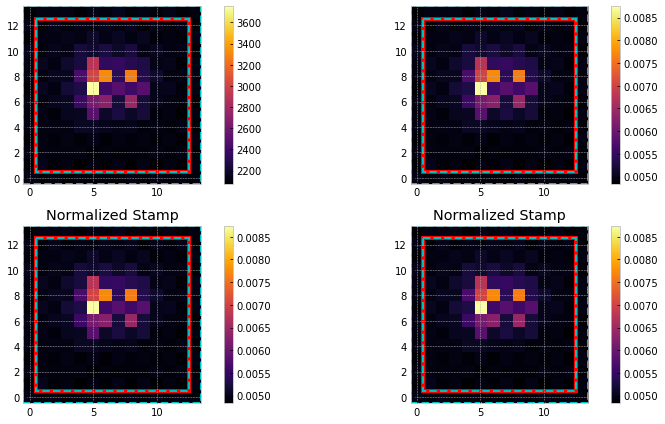

time: 1.13 s


In [14]:
# Here we are looking at the PSC and the normalized, with the normalized on bottom, so it is a repeat of information.
show_stamps(
    pscs=[
        target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), 
        normalized_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
    ], 
    stamp_size=stamp_size[0], 
    aperture_size=stamp_size[0] -2, 
    frame_idx=17) #, stretch='log')

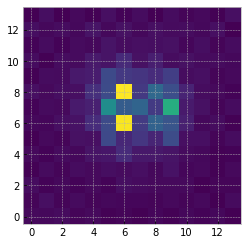

time: 7.14 s


In [33]:
# Outputs an animation that can be played. Also outputs a first frame that is annoying and in the way.
animate_stamp(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[0]))

---
### 3) Find similar stars

We want to find stars that are similar to our target in terms of how they are placed on the detector (e.g. does the star fall mostly on a red pixel or a blue, etc.).

For this we ignore the flux and directly compare the morphology of each source with the target.

* Normalize each stamp of every PSC
* Find the sum-squared-difference for each PSC when compared to the target PSC.
* Result: A score (`v`) for each point source that indicates how closely it matches the shape of the target source.

In [34]:
# Get a score for each point source for how well it matches target. Lower scores are better matches
similar_stars = observation.find_similar_stars(picid, force_new=True)

# Sort by the similarity score so we can easily get best matches
similar_source_rank = pd.DataFrame({'v': similar_stars}, index=list(observation.stamps.keys())).sort_values(by='v')

Normalizing target for 80 frames
time: 18.6 s


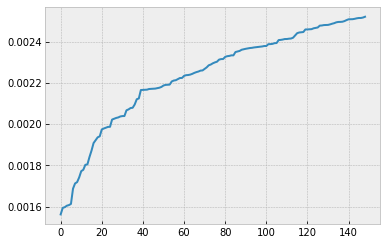

time: 221 ms


In [35]:
# Show similarity scores for top 100 matches
plt.plot(similar_source_rank.values[1:150])

### 4) Combine related stars

We want to take the reference stars that are most similar to our target and combine them into one "ideal"
template PSC. This step is done by linearly combining the normalized references to determine the proper coefficients.

In [36]:
# Guess at the number of references to start
num_refs = 100

# Damping parameter for fit
d = 0

time: 1.36 ms


In [37]:
# Build a collection of the top references. First item in list is target
ref_collection = np.array([observation.get_psc(idx, remove_bias=True) for idx in similar_source_rank.index[:num_refs]])

target_psc = ref_collection[0]

# Normalize each PSC in the reference stamp collection
normalized_collection = np.array([normalize(s) for s in ref_collection])

# Build the coeffs off the normalized PSC - this is the actual combination
coeffs = get_ideal_full_coeffs(normalized_collection, damp=d, verbose=True)

Target other shape: (15680,)
Refs other shape: (15680, 99)
time: 125 ms


In [38]:
stamp_collection = normalized_collection

num_refs = stamp_collection.shape[0] - 1
num_frames = stamp_collection.shape[1]
num_pixels = stamp_collection.shape[2]

target_frames = stamp_collection[0].flatten()
refs_frames = stamp_collection[1:].reshape(-1, num_frames * num_pixels).T

print("Target other shape: {}".format(target_frames.shape))
print("Refs other shape: {}".format(refs_frames.shape))        

def func(c0):
    return target_frames - (refs_frames * c0).sum(1)

coeffs = optimize.leastsq(func, np.ones(num_refs))
# coeffs2 = lsqr(refs_frames, target_frames, d)

Target other shape: (15680,)
Refs other shape: (15680, 99)
time: 1.35 s


In [39]:
d1 = (ref_collection[0] / (ref_collection[1:].T * coeffs[0]).T.sum(0)).sum(1)

time: 11.8 ms


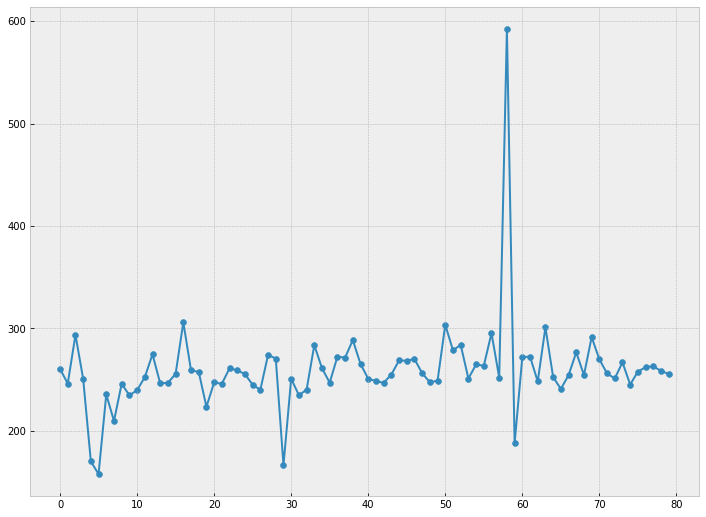

time: 375 ms


In [40]:
mean, med, std = sigma_clipped_stats(d1)
plt.figure(figsize=(12,9))
mean = 1
plt.scatter(range(observation.num_frames), d1 / mean)
plt.plot(range(observation.num_frames), d1 / mean)
# plt.ylim(.95, 1.05)

### 5) Create ideal template

We take the coefficients created from the normalized collection and apply them to the regular (non-normalized) collection.

In [41]:
# Build the template from the coeffs
ideal = get_ideal_full_psc(ref_collection, coeffs[0])

time: 7.97 ms


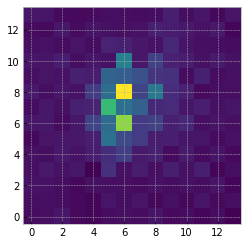

time: 7.02 s


In [42]:
# Show the generated ideal PSF
animate_stamp(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[0]))

### 6) Compare target to template

In [43]:
r_stamp_mask =np.tile(rgb_stamp_masks[0].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])
g1_stamp_mask =np.tile(rgb_stamp_masks[1].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])
g2_stamp_mask =np.tile(rgb_stamp_masks[2].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])
b_stamp_mask =np.tile(rgb_stamp_masks[3].flatten(), observation.num_frames).reshape(observation.num_frames, stamp_size[0], stamp_size[1])

time: 3.5 ms


(0, 79)

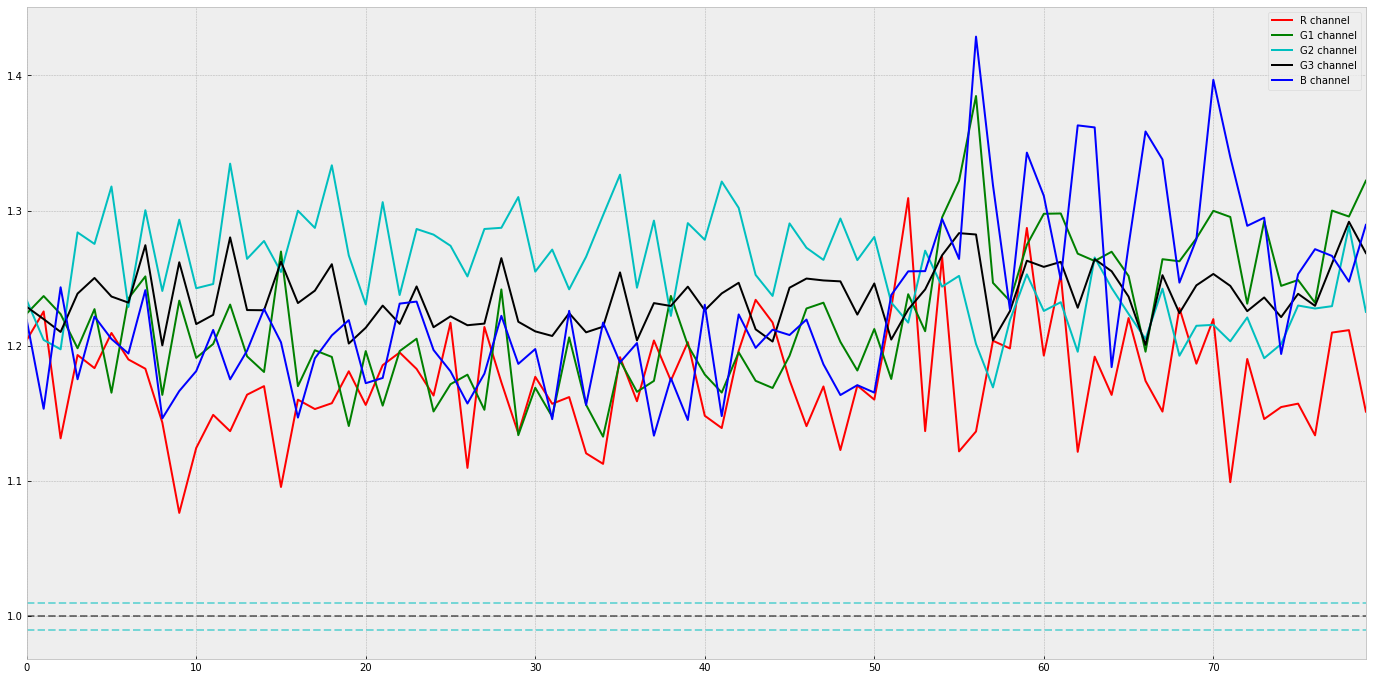

time: 961 ms


In [44]:

fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

phase = np.arange(len(target_psc))

r_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~r_stamp_mask)
g1_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g1_stamp_mask)
g2_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g2_stamp_mask)
b_target = np.ma.array(target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~b_stamp_mask)

r_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~r_stamp_mask)
g1_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g1_stamp_mask)
g2_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~g2_stamp_mask)
b_ideal = np.ma.array(ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]), mask=~b_stamp_mask)

r_diff = (r_target.reshape(observation.num_frames, -1).sum(1) / r_ideal.reshape(observation.num_frames, -1).sum(1))
g1_diff = (g1_target.reshape(observation.num_frames, -1).sum(1) / g1_ideal.reshape(observation.num_frames, -1).sum(1))
g2_diff = (g2_target.reshape(observation.num_frames, -1).sum(1) / g2_ideal.reshape(observation.num_frames, -1).sum(1))
b_diff = (b_target.reshape(observation.num_frames, -1).sum(1) / b_ideal.reshape(observation.num_frames, -1).sum(1))

g3_diff = (
    (g1_target.reshape(observation.num_frames, -1).filled(0) + g2_target.reshape(observation.num_frames, -1).filled(0)).sum(1) / 
    (g1_ideal.reshape(observation.num_frames, -1).filled(0) + g2_ideal.reshape(observation.num_frames, -1).filled(0)).sum(1)
)

r_mean, r_med, r_std = sigma_clipped_stats(r_diff)
g1_mean, g1_med, g1_std = sigma_clipped_stats(g1_diff)
g2_mean, g2_med, g1_std = sigma_clipped_stats(g2_diff)
g3_mean, g3_med, g1_std = sigma_clipped_stats(g3_diff)
b_mean, b_med, b_std = sigma_clipped_stats(b_diff)

diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]
diff2 = (target_psc.sum(1) / ideal.sum(1))

mean, median, std = sigma_clipped_stats(diff)
mean2, median2, std2 = sigma_clipped_stats(diff2)

# ax1.plot(phase, diff / mean, color='r', lw=4, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))       
# ax1.plot(phase, diff - mean + 1, color='b', lw=2, label='Pixel level')       
# ax1.plot(phase, diff2 - mean2 + 1, color='r', ls='--', lw=2, label='Stamp level')     

ax1.plot(phase, r_diff, color='r', lw=2, label='R channel')  
ax1.plot(phase, g1_diff, color='g', lw=2, label='G1 channel')  
ax1.plot(phase, g2_diff, color='c', lw=2, label='G2 channel')  
ax1.plot(phase, g3_diff, color='0', lw=2, label='G3 channel')  
ax1.plot(phase, b_diff, color='b', lw=2, label='B channel')  

ax1.hlines(1, phase[0], phase[-1], linestyles='dashed', alpha=0.5)
ax1.hlines(1.01, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')
ax1.hlines(.99, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')

ax1.legend()
# ax1.set_ylim(.95, 1.05)
ax1.set_xlim(phase[0], phase[-1])

---
#### Try different number of references

Here we run through a range of references and damping values. Note that this is running pipeline steps 3-6 for each set of values.

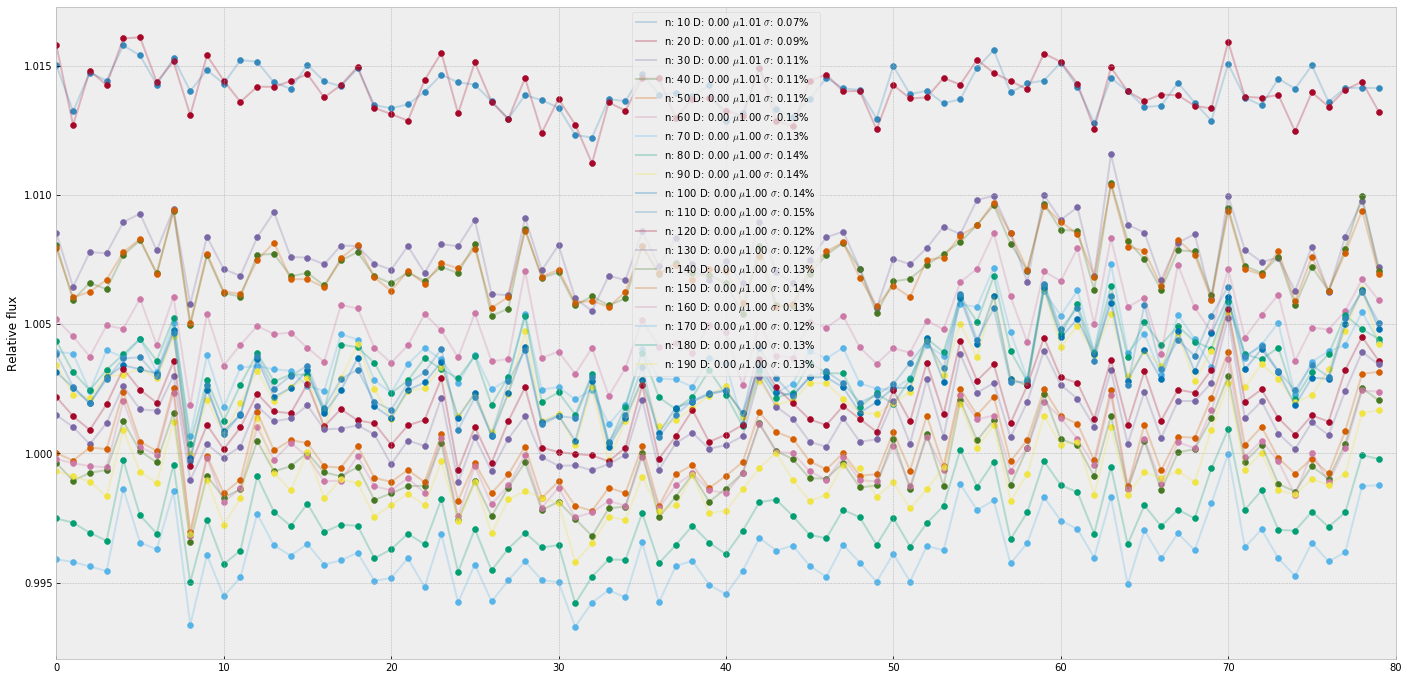

time: 4.77 s


In [45]:
fig = plt.figure(figsize=(24,12))
ax1 = fig.add_subplot(111)

def normalize(cube):
    return (cube.T / cube.sum(1)).T

for num_refs in np.arange(10, 200, 10):
    for d in np.arange(0, 5, 5):
        
        # Get all reference PSC
        stamp_collection = np.array([observation.get_psc(idx) for idx in similar_source_rank.index[:num_refs]])
        # Normalize each PSC
        normalized_collection = np.array([normalize(s) for s in stamp_collection])

        # Build the coeffs off the normalized PSC
        coeffs = get_ideal_full_coeffs(normalized_collection, damp=d)

        # Build the template from the coeffs
        ideal = get_ideal_full_psc(stamp_collection, coeffs[0])

        target_psc = stamp_collection[0]

#         diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]
#         diff = diff / np.median(diff)
        diff = (target_psc.sum(1) / ideal.sum(1))

        mean, median, std = sigma_clipped_stats(diff)

        # Skip those that have a high std
#         if std / mean > .05:
#             continue

#         ax1.plot(phase, diff, alpha=0.25, label='n: {} D: {:.2f} $\mu$: {:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std / mean))   
        ax1.plot(diff, alpha=0.25, label='n: {} D: {:.2f} $\mu${:.02f} $\sigma$: {:.02%}'.format(num_refs, d, mean, std))   
#         ax1.scatter(phase, diff)   
        ax1.scatter(np.arange(len(diff)), diff)


# plt.plot(diff)
# plt.plot(psc.sum(1) / np.median(psc.sum(1)))

x_min = 0 
x_max = len(diff)
# x_min = phase.min()
# x_max = phase.max()
# ax1.hlines(1, x_min, x_max, linestyles='dashed', alpha=0.5)
# ax1.set_ylim(.8, 1.2)
ax1.set_xlim(x_min, x_max)

# ax1.set_xlabel('Phase')
ax1.set_ylabel('Relative flux')
ax1.legend()

# ax1.set_title("Relative photometry")

#### Run reduction

Here we have a fixed `num_refs` and damping value `d` and make a `run_piaa` method that runs reduction steps.

In [46]:
def normalize(cube):
    return (cube.T / cube.sum(1)).T

def run_piaa(picid, num_refs=50, damp=0):
    print("Getting similar sources")
    vary = observation.find_similar_stars(picid, force_new=True, display_progress=False)
    vary_series = pd.DataFrame({'v': vary}, index=list(observation.stamps.keys())).sort_values(by='v')

    print("Building collection")
    ref_collection = np.array([observation.get_psc(idx, remove_bias=False) for idx in vary_series.index[:num_refs]])
#     print(ref_collection.shape)

    # Normalize each PSC
    print("Normalizing collection")
    normalized_collection = np.array([normalize(s) for s in ref_collection])
    

    # Build the coeffs off the normalized PSC
    print("Getting coefficients")
    coeffs = get_ideal_full_coeffs(normalized_collection, damp=damp)
#     print(normalized_collection)

    # Build the template from the coeffs with non-normalized data
    print("Building ideal stamp")
    ideal = get_ideal_full_psc(ref_collection, coeffs[0]).reshape(observation.num_frames, -1)

    target_psc = ref_collection[0].reshape(observation.num_frames, -1)

#     diff = (target_psc / ideal).sum(1) / target_psc.shape[-1]

    diff = list()
    for frame_idx in range(observation.num_frames):
        d0 = target_psc[frame_idx].reshape(stamp_size[0], stamp_size[1])
        i0 = ideal[frame_idx].reshape(stamp_size[0], stamp_size[1])
        
        mean, median, std = sigma_clipped_stats(d0)
        threshold = median + (5 * std)
        try:
           peak_tbl = find_peaks(d0, threshold)
        except Exception as e:  # No peaks found
           print("Error: ", e)
#                         print("No peak found on {}".format(frame_idx))
           continue
    
        try:
           position = (peak_tbl['x_peak'][0], peak_tbl['y_peak'][0])
        except IndexError:
           print("No peaks: ", frame_idx)
           position = (5, 4)
        
        d1 = Cutout2D(d0, position, aperture_size, mode='trim')
        i1 = Cutout2D(i0, position, aperture_size, mode='trim')
        
        d2 = d1.data
        i2 = i1.data
        
#         print(d2.shape, i2.shape)
        
        r_mask = ~rgb_stamp_masks[0][d1.slices_original]
        g1_mask = ~rgb_stamp_masks[1][d1.slices_original]
        g2_mask = ~rgb_stamp_masks[2][d1.slices_original]
        b_mask = ~rgb_stamp_masks[3][d1.slices_original]
        
        r_target = np.ma.array(d2, mask=r_mask)
        g1_target = np.ma.array(d2, mask=g1_mask)
        g2_target = np.ma.array(d2, mask=g2_mask)
        b_target = np.ma.array(d2, mask=b_mask)

        r_ideal = np.ma.array(i2, mask=r_mask)
        g1_ideal = np.ma.array(i2, mask=g1_mask)
        g2_ideal = np.ma.array(i2, mask=g2_mask)
        b_ideal = np.ma.array(i2, mask=b_mask)
                
#         print(r_target.shape)
#         print(r_ideal.shape)
        r_diff = (r_target.sum() / r_ideal.sum())
        g1_diff = (g1_target.sum() / g1_ideal.sum())
        g2_diff = (g2_target.sum() / g2_ideal.sum())
        g3_diff = ((g1_target.filled(0) + g2_target.filled(0)).sum() / (g1_ideal.filled(0) + g2_ideal.filled(0)).sum())
        b_diff = (b_target.sum() / b_ideal.sum())

#         shape = (stamp_size[0] * stamp_size[1])
        shape = (d0.shape[0] * d0.shape[1])
        div_sum = (d0 / i0).sum() / shape
       
        total_diff = d2.sum() / i2.sum()

        results = (
            r_diff,
            g3_diff,            
            b_diff,
            g1_diff,
            g2_diff,
            total_diff,
            div_sum
        )
        diff.append(results)
        
        
    diff_group.create_dataset(picid, data=np.array(diff), dtype='f4')
    
    return ideal

time: 16.3 ms


In [47]:
num_refs = 100
d = 0

aperture_size = 6

try:
    diff_group = observation.hdf5_stamps.create_group('diffs')
except ValueError:
    diff_group = observation.hdf5_stamps['diffs']

time: 3.46 ms


In [48]:
# # Run for all stamps - WILL TAKE A LONG TIME
# observation.verbose = False
# for picid in tqdm_notebook(observation.stamps.keys()):        
#     if picid in diff_group:
#         continue

# #     psc = observation.get_psc(picid).reshape(observation.num_frames, -1)
# #     normalized_psc = normalize(psc)

#     run_piaa(picid)

# observation.verbose = True

time: 2.01 ms


In [49]:
# A random high snr point source
picid = high_snr[np.random.randint(len(high_snr))]
picid

'350346969'

time: 8.61 ms


In [50]:
# The assigned target
picid = ticid
picid

'393495970'

time: 5.12 ms


In [51]:
# Run for one stamp
try:
    del observation.hdf5_stamps['diffs'][picid]
except KeyError:
    pass

ideal = run_piaa(picid, num_refs=num_refs)

Getting similar sources
Normalizing target for 80 frames
Building collection
Normalizing collection
Getting coefficients
Building ideal stamp
time: 19.4 s


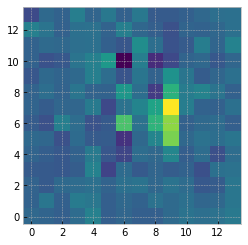

time: 7.07 s


In [52]:
t0 = target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) / ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
animate_stamp(t0)

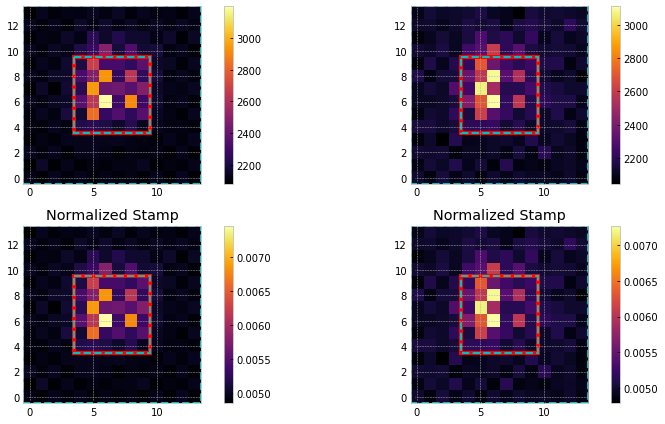

time: 1.24 s


In [53]:
# Show comparison of target and created ideal
show_stamps(pscs=[
            target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]),
            ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
        ], 
        stamp_size=stamp_size[0], 
        aperture_size=aperture_size, 
        frame_idx=1
           )#, stretch='log')

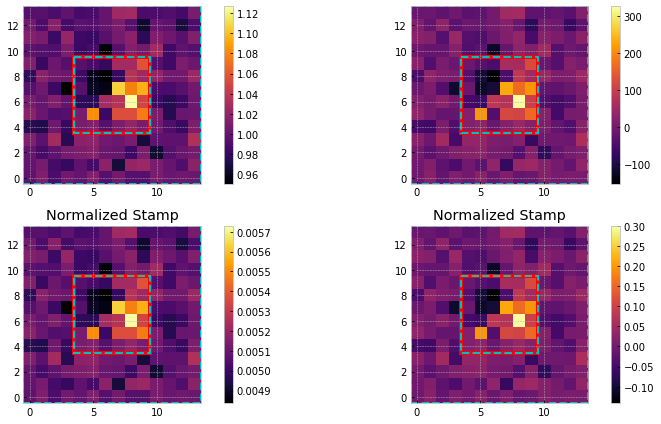

time: 1.08 s


In [54]:
# Show some residuals of the target and comparison
show_stamps(pscs=[
            target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) / ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1]),
            target_psc.reshape(observation.num_frames, stamp_size[0], stamp_size[1]) - ideal.reshape(observation.num_frames, stamp_size[0], stamp_size[1])
        ], 
        stamp_size=stamp_size[0], 
        aperture_size=aperture_size, 
        frame_idx=1
        ) #, stretch='log')

---
**Scratchpad below**

Get some information about the transit

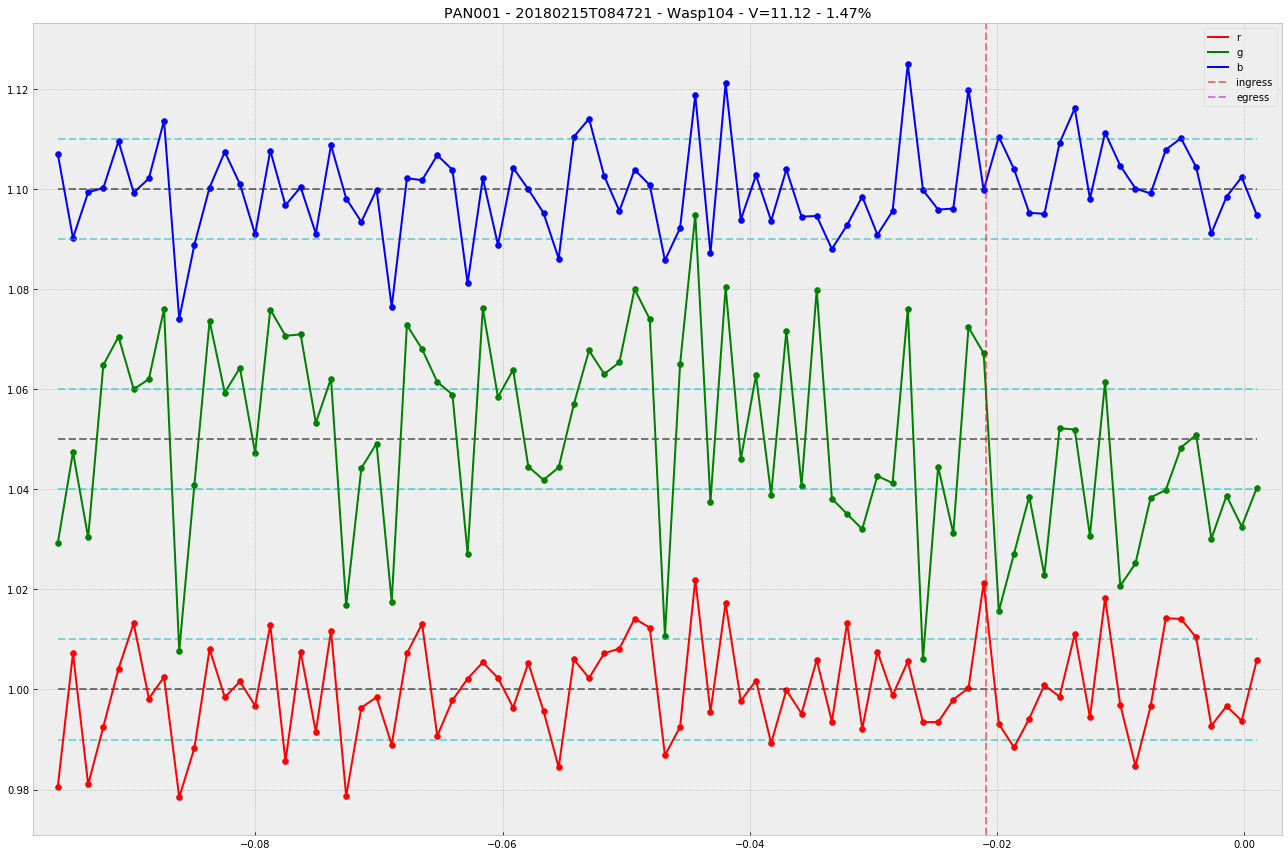

time: 1.18 s


In [67]:
y = np.array(observation.hdf5_stamps['diffs'][picid])

plt.figure(figsize=(18,12))

ingress_phase = observation.planet.get_phase(observation.transit_info.ingress)
egress_phase = observation.planet.get_phase(observation.transit_info.egress)

obs_start_phase = observation.planet.get_phase(list(observation.image_times.keys())[0])
obs_stop_phase = observation.planet.get_phase(list(observation.image_times.keys())[-1])

# phase = np.arange(len(target_psc))
phase = np.linspace(obs_start_phase, obs_stop_phase, observation.num_frames)

for i, color in zip(range(y.shape[1]), ['r', 'g', 'b', 'g', 'g', 'k', 'k']):
    if i > 2: continue
        
    d0 = y[:, i]
    mean, med, std = sigma_clipped_stats(d0)
    
    d0 /= mean
    
    # Offset lines from each other
    offset = i / 20
    d0 += offset

    plt.plot(phase, d0, color=color, label=color)
#     plt.scatter(range(observation.num_frames), d0, color=color)
    plt.scatter(phase, d0, color=color)
    
    plt.hlines(1 + offset, phase[0], phase[-1], linestyles='dashed', alpha=0.5)
    plt.hlines(1.01 + offset, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')
    plt.hlines(.99 + offset, phase[0], phase[-1], linestyles='dashed', alpha=0.5, color='c')    
        

plt.axvline(ingress_phase, 0, color='r', ls='--', alpha=0.5, label='ingress')
plt.axvline(egress_phase, 0, color='m', ls='--', alpha=0.5, label='egress')
        
# plt.ylim(0.9, 1.1)
# plt.xlim(0, len(target_psc))
plt.xlim(phase[0] - .002, phase[-1] + .002)

plt.legend()
plt.title("{} - {} - {} - V={} - {:.02%}".format(
    observation.unit_it,
    observation.seq_id,
    observation.field,
    observation.planet.star_mag, 
    observation.planet.transit_depth / 100
))
plt.tight_layout()
plt.savefig('{}.png'.format(seq_id.replace('/', '_')))